# Examining the Frequencies and Hypothetical Drift Rates

This notebook is going to be looking at the frequencies of the hits. Then I will filter out all of the hits that were observed at two different time stamps. By looking at the hits that were at the same source and observed twice, I will calculate what the drift rate would need to be in order to match one signal with another. This should also help to indicate which of the hits are persistently at zero drift and which ones are not. Some of those signals could be drifting so it will be important to see which those are. 

I will start by importing all of the necessary packages below. All of the versions of the packages are listed in the README.md file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv

Start by opening the file that has only the sources that were observed at two different start times. This file was created in another Jupyter Notebook.

In [2]:
with open('../../Pickle_Files/drift_space.pkl', 'rb') as f:

    drift_space = pickle.load(f) # deserialize using load()
    
print(drift_space.shape)

(114174, 24)


Now before looking at the different times, I want to see what is going on between the different frequencies, powers, and signal to noise ratios. What is also obvious in this plot is how most of the time the power and the signal to noise ratio are directly corrolated. But it could be interesting to look a little bit more into those few sources that have a high signal power and a comparatively low signal to noise ratio. 

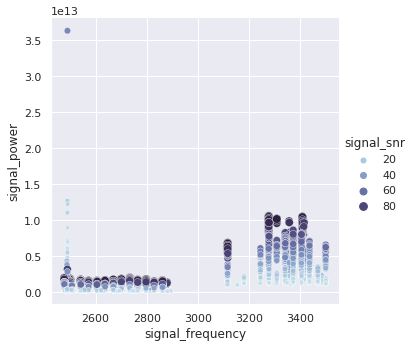

In [3]:
sns.set_theme()
sns.relplot(data=drift_space, x=drift_space["signal_frequency"], y=drift_space["signal_power"], 
            hue=drift_space["signal_snr"], size = drift_space["signal_snr"], palette = "ch:s=.25,rot=-.25")
plt.savefig('drift_space.png', bbox_inches='tight', transparent = True)

Taking a look at the number of sources in the pickle file. Also looking at how many hits of each source are present in the file.

In [55]:
source_name = np.array(drift_space['sourceName']) #The name of the source in the drift_space file
unique_source_name = np.unique(source_name) #The array of unique source names

length_of_sources = [] #The number of hits at each of the unique sources
for i in tqdm(range(len(unique_source_name))):
    source = drift_space.loc[source_name == unique_source_name[i]] #select each subset
    length_of_sources.append(np.count_nonzero(array == int(unique_source_name[i])))

100%|██████████| 829/829 [00:03<00:00, 221.13it/s]


Now let's get the frequency bins loaded in from Jared's frequency kurtosis. These are the preliminary frequency bins, so another set of frequencies can also be loaded in. It is set up as a .csv file. I first opened it, using just the open command to be able to read in the first row of the data set. Then I opened it using pandas and defined both of the columns using the information provided in the first row of the csv. The two columns give the upper and lower frequencies for the bins.

In [56]:
source = '../../Preliminary_Data_Files/prelim_kurt_bins.csv' #define the csv file

with open(source, newline='') as f: #read in the csv file and then look at just the first row
    reader = csv.reader(f)
    row1 = next(reader)
    
print(row1) #print out the first row: the headers

data = pd.read_csv(source) #open the csv file using pandas

lower_freq_bin = [float(x) for x in data['rfi_freq_bin_bots'] if str(x) != 'nan'] #define the lower end of the bin
upper_freq_bin = [float(x) for x in data['rfi_freq_bin_tops'] if str(x) != 'nan'] #define the upper end of the bin
#also remove any nans that got tacked on to the end of the columns

['rfi_freq_bin_bots', 'rfi_freq_bin_tops']


Now remove any of the hits that have frequencies within the bins that had a high and persistent kurtosis value. This is examined further in the CRICKETS package, designed by Jared Sofair. Further information to this package and the GitHub repository will be linked in the README.md.

All of the indicies of the hits that are being removed will be put together in a list. The this will be subtracted out of the list of the indicies of the entire set of hits. So it will be put together as a set, then subtracted, and finally put back together as a list to be able to take those rows in the dataframe.

In [57]:
signal_frequency = list(np.array(drift_space['signal_frequency'])) #define the list of the frequencies

discarded_frequencies = [] #make a list of the indicies of the frequencies that will be discarded
for i in tqdm(range(len(sourceName))): #looping through all of the hits
    for j in range(len(lower_freq_bin)): #looping through all of the high kurtosis frequency bins
        if signal_frequency[i] > lower_freq_bin[j] and signal_frequency[i] < upper_freq_bin[j]: 
            discarded_frequencies.append(i) #append if the frequency is inside of one of the bins
print(discarded_frequencies[0:5]) #making sure that it did what I intended

100%|██████████| 114174/114174 [00:04<00:00, 22855.96it/s]

[0, 1, 2, 3, 55]


In [58]:
kept_frequencies = list(set(range(len(signal_frequency))) - set(discarded_frequencies)) 
#Removing the indicies of the frequencies (and hits) to be discarded so we are left with just a list of the rows that I want
#to keep

Now using the indicies of the kept frequencies, I am going to go through and only keep those indexed rows of the dataframe. As a reminder, this is the dataframe of all of the hits that are present in sources that were observed twice. This is also after there was a cut done to the signal to noise ratio and all of the hits that were present in all six of the beams were removed.

In [10]:
######### Open up a blank dataframe that has all of the same headers #########
df1 = pd.DataFrame({"file_path":[],
                    "hit_file_enumeration":[],
                    "signal_frequency":[],
                    "signal_index":[],
                    "signal_driftSteps":[],
                    "signal_driftRate":[],
                    "signal_snr":[],
                    "signal_coarseChannel":[],
                    "signal_numTimesteps":[],
                    "signal_power":[],
                    "signal_incoherentPower":[],
                    "sourceName":[],
                    "fch1":[],
                    "foff":[],
                    "tstart":[],
                    "tsamp":[],
                    "ra":[],
                    "dec":[],
                    "telescopeId":[],
                    "numTimesteps":[],
                    "numChannels":[],
                    "coarseChannel":[],
                    "startChannel":[],
                    "beam":[]})

for i in tqdm(range(len(source_name))): #Going through the list of all of the hits
    new_source = drift_space.loc[source_name == source_name[i]] #select each row of the original dataframe
    
    if i in kept_frequencies:
        appending_rows = new_source.loc[i] #Keep only the hits where the index matches the number in the list of kept rows
    
        df1 = df1.append(appending_rows, ignore_index = True)

with open('../../Pickle_Files/drift_space_kurtosis.pkl', 'wb') as f:  # open a text file
    pickle.dump(df1, f) # serialize the list
f.close()

100%|██████████| 114174/114174 [17:02<00:00, 111.71it/s]


,file_path,hit_file_enumeration,signal_frequency,signal_index,signal_driftSteps,signal_driftRate,signal_snr,signal_coarseChannel,signal_numTimesteps,signal_power,...,tstart,tsamp,ra,dec,telescopeId,numTimesteps,numChannels,coarseChannel,startChannel,beam
0,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,265.0,2487.361481,47380.0,-12.0,-11.087174,10.067541,10.0,64.0,3.083943e+11,...,60006.080477,0.131072,3.46006,8.24895,0.0,64.0,91.0,10.0,47328.0,2.0
1,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,285.0,2488.824272,108039.0,1.0,0.923931,9.292659,11.0,64.0,2.707338e+11,...,60006.080477,0.131072,3.46006,8.24895,0.0,64.0,80.0,11.0,107999.0,2.0
2,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,293.0,2491.760864,99728.0,25.0,23.098278,9.259498,14.0,64.0,3.102176e+11,...,60006.080477,0.131072,3.46006,8.24895,0.0,64.0,104.0,14.0,99688.0,2.0
3,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,321.0,2502.645248,84574.0,0.0,0.000000,8.156948,25.0,64.0,2.340233e+11,...,60006.080477,0.131072,3.46006,8.24895,0.0,64.0,79.0,25.0,84534.0,2.0
4,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,322.0,2502.648300,84974.0,0.0,0.000000,9.378388,25.0,64.0,2.560867e+11,...,60006.080477,0.131072,3.46006,8.24895,0.0,64.0,79.0,25.0,84934.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105026,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,73.0,3436.764023,100142.0,0.0,0.000000,57.193813,31.0,64.0,6.500899e+12,...,60006.147386,0.131072,3.60406,11.67010,0.0,64.0,79.0,31.0,100102.0,2.0
105027,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,74.0,3436.797371,104513.0,0.0,0.000000,31.485077,31.0,64.0,3.804582e+12,...,60006.147386,0.131072,3.60406,11.67010,0.0,64.0,79.0,31.0,104473.0,2.0
105028,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,75.0,3436.799904,104845.0,0.0,0.000000,34.453175,31.0,64.0,4.115874e+12,...,60006.147386,0.131072,3.60406,11.67010,0.0,64.0,79.0,31.0,104805.0,2.0
105029,/mnt/cosmic-storage-1/data2/vlass_target/VLASS...,76.0,3436.826302,108305.0,0.0,0.000000,42.857834,31.0,64.0,4.997350e+12,...,60006.147386,0.131072,3.60406,11.67010,0.0,64.0,79.0,31.0,108265.0,2.0


In [59]:
with open('../../Pickle_Files/drift_space_kurtosis.pkl', 'rb') as f:
    drift_space_kurtosis = pickle.load(f) # deserialize using load()
    
print(drift_space_kurtosis.shape)

(105031, 24)


Now look at the same figure that I showed earlier to see if there are any noteworthy differences. But, because there are still so many hits, it is pretty difficult to see any differences.

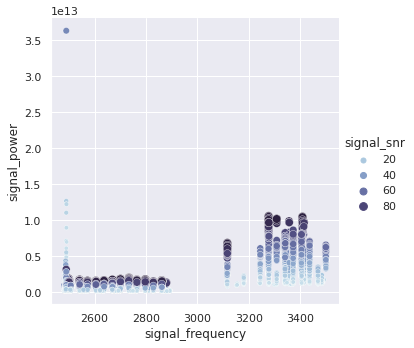

In [13]:
sns.set_theme()
sns.relplot(data=drift_space_kurtosis, x=drift_space_kurtosis["signal_frequency"], y=drift_space_kurtosis["signal_power"], 
            hue=drift_space_kurtosis["signal_snr"], size = drift_space_kurtosis["signal_snr"], palette = "ch:s=.25,rot=-.25")
plt.savefig('../../Figures/drift_space_kurtosis.png', bbox_inches='tight', transparent = True)

Now I am going to split up the previous pickle files into two smaller files. These two files will be with each of the observation times of each of the sources. So each file will have all of the original source names, but all of the hits with the first start time will be in one pickle file and all of the hits with the second start time will be in the second pickle file. This should make it easier to compare the hits from the two observation times.

In [63]:
######## start out with the empty dataframe for the first set of observations ########
df1 = pd.DataFrame({"file_path":[],
                    "hit_file_enumeration":[],
                    "signal_frequency":[],
                    "signal_index":[],
                    "signal_driftSteps":[],
                    "signal_driftRate":[],
                    "signal_snr":[],
                    "signal_coarseChannel":[],
                    "signal_numTimesteps":[],
                    "signal_power":[],
                    "signal_incoherentPower":[],
                    "sourceName":[],
                    "fch1":[],
                    "foff":[],
                    "tstart":[],
                    "tsamp":[],
                    "ra":[],
                    "dec":[],
                    "telescopeId":[],
                    "numTimesteps":[],
                    "numChannels":[],
                    "coarseChannel":[],
                    "startChannel":[],
                    "beam":[]})

######## start out with the empty dataframe for the second set of observations ########
df2 = pd.DataFrame({"file_path":[],
                    "hit_file_enumeration":[],
                    "signal_frequency":[],
                    "signal_index":[],
                    "signal_driftSteps":[],
                    "signal_driftRate":[],
                    "signal_snr":[],
                    "signal_coarseChannel":[],
                    "signal_numTimesteps":[],
                    "signal_power":[],
                    "signal_incoherentPower":[],
                    "sourceName":[],
                    "fch1":[],
                    "foff":[],
                    "tstart":[],
                    "tsamp":[],
                    "ra":[],
                    "dec":[],
                    "telescopeId":[],
                    "numTimesteps":[],
                    "numChannels":[],
                    "coarseChannel":[],
                    "startChannel":[],
                    "beam":[]})

unique_source = np.unique(drift_space_kurtosis['sourceName'])
print(len(unique_source))

for i in range(len(unique_source)):
    fov_subset = drift_space_kurtosis.loc[drift_space_kurtosis['sourceName'] == unique_source[i]] #select each subset
    
    start_time = np.array(fov_subset["tstart"]) #define the column for the start time
    unique_start_time = np.unique(start_time) #Look at the two unique start times for each of the sources
    
    indices_1 = np.where(np.array(start_time) != unique_start_time[0])
    time_1 = np.array(start_time)[indices_1]
    
    indices_2 = np.where(np.array(start_time) != unique_start_time[1])
    time_2 = np.array(start_time)[indices_2]
    
    new_indices_1 = np.concatenate(np.where(np.isin(np.array(start_time), time_1) == True))
    appending_rows_1 = fov_subset.iloc[new_indices_1]
    df1 = df1.append(appending_rows_1, ignore_index = True)
    
    new_indices_2 = np.concatenate(np.where(np.isin(np.array(start_time), time_2) == True))
    appending_rows_2 = fov_subset.iloc[new_indices_2]
    df2 = df2.append(appending_rows_2, ignore_index = True)
    
print(df1.shape, df2.shape)

with open('../../Pickle_Files/drift_time_kurtosis_1.pkl', 'wb') as f:  # open a text file
    pickle.dump(df1, f) # serialize the list
f.close()

with open('../../Pickle_Files/drift_time_kurtosis_2.pkl', 'wb') as f:  # open a text file
    pickle.dump(df2, f) # serialize the list
f.close()

829
(55049, 24) (49982, 24)


Now open up those two new pickle files to start working with them.

In [64]:
with open('../../Pickle_Files/drift_time_kurtosis_1.pkl', 'rb') as f:
    drift_time_1_kurtosis = pickle.load(f) # deserialize using load()
    
print(drift_time_1_kurtosis.shape)
    
with open('../../Pickle_Files/drift_time_kurtosis_2.pkl', 'rb') as f:
    drift_time_2_kurtosis = pickle.load(f) # deserialize using load()
    
print(drift_time_2_kurtosis.shape)

(55049, 24)
(49982, 24)


Define the arrays of the source names and the unique source names. This will be used a little later. It also helps to confirm that each of the new dataframes are the right shapes and have all of the correct information.

In [65]:
source_name_1 = np.array(drift_time_1_kurtosis["sourceName"])
unique_source_name_1 = np.unique(source_name_1)

source_name_2 = np.array(drift_time_2_kurtosis["sourceName"])
unique_source_name_2 = np.unique(source_name_2)

print(len(unique_source_name_1), len(unique_source_name_2))

829 829


Now I am going to start to make matches between the hits in the same source but at different start times. I am doing this by calculating the time differences and the frequency differences between each of the hits at the same source at the two different time observations. In order to not have millions of combinations of hits, which would occur if I set no bounds on this, I am requiring that there be no greater than a 20% difference in the powers and a calculated hypothetical drift rate no greater than 100 Hz/s.

In [73]:
driftRate = []
timeDiffs = []
freqDiffs = []
powDiffs = []

driftRates = pd.DataFrame({"Source Name":[], #Gaia name of the source
                           "Drift Rate":[], #Coherent or incoherent beam
                           "Time Difference":[], 
                           "Frequency 1":[],
                           "Frequency 2":[],
                           "Frequency Difference":[],
                           "Power 1":[],
                           "Power 2":[],
                           "Power Difference":[],
                           "Start Time 1":[],
                           "Start Time 2":[]})
for i in tqdm(range(len(unique_source_name_1))):
#for i in range(6):
    source_1 = drift_time_1_kurtosis.loc[source_name_1 == unique_source_name_1[i]] #select each subset
    source_2 = drift_time_2_kurtosis.loc[source_name_2 == unique_source_name_1[i]] #select each subset
    
    frequency_1 = np.array(source_1["signal_frequency"])
    start_time_1 = np.array(source_1["tstart"])
    power_1 = np.array(source_1["signal_power"])
    
    frequency_2 = np.array(source_2["signal_frequency"])
    start_time_2 = np.array(source_2["tstart"])
    power_2 = np.array(source_2["signal_power"])
    
    DriftRate = []
    FrequencyDifference = []
    PowerDifference = []
    
    freq_1 = []
    freq_2 = []
    pow_1 = []
    pow_2 = []
    
    time_diff = (start_time_2[0] - start_time_1[0])*24*60*60 #the time between the two observations
    maximum_drift = time_diff*100 #assuming a maximum drift rate of 100 Hz/s, the maximum a signal could have drifted
    
    for x in range(len(source_1)):
        for y in range(len(source_2)):
            freq_diff = (frequency_1[x]-frequency_2[y])*1e6
            pow_diff = ((power_2[y]-power_1[x])/((power_1[x] + power_2[y])/2))*100

            drift = freq_diff/time_diff
            
            if np.abs(freq_diff) < np.abs(maximum_drift):
                if np.abs(pow_diff) < 20:
                    DriftRate.append(drift)
                    FrequencyDifference.append(freq_diff)
                    PowerDifference.append(pow_diff)
                    
                    freq_1.append(frequency_1[x])
                    freq_2.append(frequency_2[y])
                    pow_1.append(power_1[x])
                    pow_2.append(power_2[y])
    
    TimeDifference = np.full(len(DriftRate), time_diff)
    
    for j in range(len(DriftRate)):
        new_row = [unique_source_name_1[i], DriftRate[j], TimeDifference[j], freq_1[j], freq_2[j], FrequencyDifference[j], 
                   pow_1[j], pow_2[j], PowerDifference[j], start_time_1[0], start_time_2[0]]

        driftRates.loc[len(driftRates.index)] = new_row

display(driftRates)

with open('../../Pickle_Files/drift_rate_kurtosis.pkl', 'wb') as f:  # open a text file
    pickle.dump(driftRates, f) # serialize the list
f.close()

100%|██████████| 829/829 [00:37<00:00, 22.04it/s]


,Source Name,Drift Rate,Time Difference,Frequency 1,Frequency 2,Frequency Difference,Power 1,Power 2,Power Difference,Start Time 1,Start Time 2
0,10130217239302528,-72.737910,-297.359844,2505.482574,2505.460945,21629.333496,3.542508e+11,3.753997e+11,5.797010,60006.083918,60006.080477
1,10130217239302528,-76.073334,-297.359844,2505.482574,2505.459953,22621.154785,3.542508e+11,3.702758e+11,4.423577,60006.083918,60006.080477
2,10130217239302528,-67.247288,-297.359844,2505.480942,2505.460945,19996.643066,3.302722e+11,3.753997e+11,12.789946,60006.083918,60006.080477
3,10130217239302528,-70.582713,-297.359844,2505.480942,2505.459953,20988.464355,3.302722e+11,3.702758e+11,11.420650,60006.083918,60006.080477
4,10130217239302528,-75.329278,-297.359844,2557.402290,2557.379890,22399.902344,2.465902e+11,2.599866e+11,5.288989,60006.083918,60006.080477
...,...,...,...,...,...,...,...,...,...,...,...
7901,37456066191234048,-0.000000,-152.330898,2621.424889,2621.424889,0.000000,2.024020e+11,2.302339e+11,12.866220,60006.147386,60006.145623
7902,37456066191234048,-0.000000,-152.330898,2621.379890,2621.379890,0.000000,2.118394e+11,2.216533e+11,4.527835,60006.147386,60006.145623
7903,37456066191234048,-0.000000,-152.330898,2621.355293,2621.355293,0.000000,3.205819e+11,3.205750e+11,-0.002147,60006.147386,60006.145623
7904,37456066191234048,13.773197,-152.330898,2742.264847,2742.266945,-2098.083496,2.734394e+11,2.638065e+11,-3.586045,60006.147386,60006.145623


In [74]:
with open('../../Pickle_Files/drift_rate_kurtosis.pkl', 'rb') as f:
    drift_rate_kurtosis = pickle.load(f) # deserialize using load()
    
print(drift_rate_kurtosis.shape)

(7906, 11)


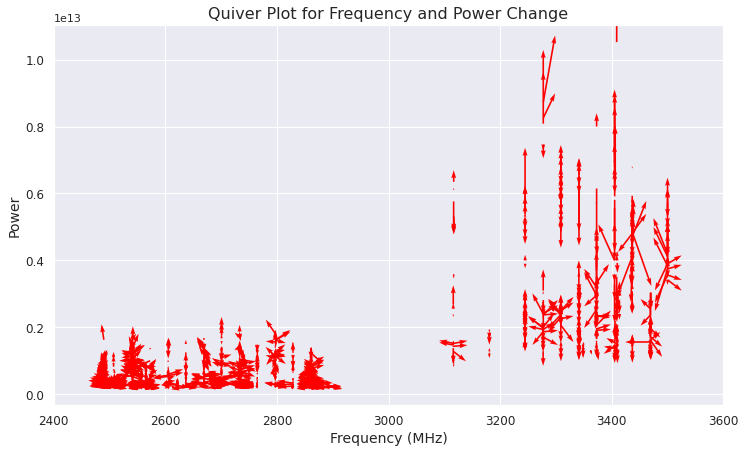

In [83]:
# Creating arrow
x_pos = driftRates['Frequency 1']
y_pos = driftRates['Power 1']
x_direct = driftRates['Frequency Difference']/1e6 #Make sure that all of the frequency differences are in MHz
y_direct = np.array(driftRates['Power 1'] - driftRates['Power 2'])/1e13
source = np.unique(np.array(driftRates['Source Name']))

# Creating plot
fig, ax = plt.subplots(figsize = (12, 7))

ax.quiver(x_pos, y_pos, x_direct, y_direct, color = 'red')

ax.set_title('Quiver Plot for Frequency and Power Change', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Frequency (MHz)', fontsize = 14)
plt.ylabel('Power', fontsize = 14)
plt.xlim(2400, 3600)
#plt.grid()

# Show plot
plt.show()

Now something that is noteworthy here is how many of the pairings have zero drift. This is something kind of interesting because it more conclusively shows all of the hits that definitely have zero drift over that more extended period of time. So I am going to first remove all of those hits. But a lot of the hits that we determined to have zero drift have hypothetical drift rates calculated by pairings with other hits at the same source. So, these combinations also need to be removed so that it is not as wildly oversampled. 

In this first part, I am going to make a new pickle file with all of the combinations that have nonzero drift rates. The second part of the next cell will make the pickle file that has all of the hits with the zero drift. These will then be exported to new pickle files. But there is still the issue of the combinations with nonzero drift rates having pairs with the frequencies that we now know to have zero drift. So I'll then use the file that has the information for the zero drift to remove all of those combinations too.

In [87]:
driftRates_1 = pd.DataFrame({"Source Name":[], #Gaia name of the source
                           "Drift Rate":[], #Coherent or incoherent beam
                           "Time Difference":[], 
                           "Frequency 1":[],
                           "Frequency 2":[],
                           "Frequency Difference":[],
                           "Power 1":[],
                           "Power 2":[],
                           "Power Difference":[],
                           "Start Time 1":[],
                           "Start Time 2":[]})

source_name = np.array(drift_rate_kurtosis["Source Name"])

for i in tqdm(range(len(source_name))):
    new_source = drift_rate_kurtosis.loc[source_name == source_name[i]] #select each subset
    
    if np.array(drift_rate_kurtosis["Drift Rate"])[i] != 0:
        appending_rows = new_source.loc[i]
    
            #display(appending_rows)
        driftRates_1 = driftRates_1.append(appending_rows, ignore_index = True)
    else:
        continue

display(driftRates_1)

with open('../../Pickle_Files/drift_rate_kurtosis_nonzero.pkl', 'wb') as f:  # open a text file
    pickle.dump(driftRates_1, f) # serialize the list
f.close()

##############################################################################################################################

driftRates_2 = pd.DataFrame({"Source Name":[], #Gaia name of the source
                           "Drift Rate":[], #Coherent or incoherent beam
                           "Time Difference":[], 
                           "Frequency 1":[],
                           "Frequency 2":[],
                           "Frequency Difference":[],
                           "Power 1":[],
                           "Power 2":[],
                           "Power Difference":[],
                           "Start Time 1":[],
                           "Start Time 2":[]})

source_name = np.array(drift_rate_kurtosis["Source Name"])

for i in tqdm(range(len(source_name))):
    new_source = drift_rate_kurtosis.loc[source_name == source_name[i]] #select each subset
    
    if np.array(drift_rate_kurtosis["Drift Rate"])[i] == 0:
        appending_rows = new_source.loc[i]
    
            #display(appending_rows)
        driftRates_2 = driftRates_2.append(appending_rows, ignore_index = True)
    else:
        continue

display(driftRates_2)

with open('../../Pickle_Files/drift_rate_kurtosis_zero.pkl', 'wb') as f:  # open a text file
    pickle.dump(driftRates_2, f) # serialize the list
f.close()

100%|██████████| 7906/7906 [00:16<00:00, 483.10it/s]


,Source Name,Drift Rate,Time Difference,Frequency 1,Frequency 2,Frequency Difference,Power 1,Power 2,Power Difference,Start Time 1,Start Time 2
0,10130217239302528,-72.737910,297.359844,2505.460945,2505.482574,-21629.333496,3.753997e+11,3.542508e+11,-5.797010,60006.080477,60006.083918
1,10130217239302528,-67.247288,297.359844,2505.460945,2505.480942,-19996.643066,3.753997e+11,3.302722e+11,-12.789946,60006.080477,60006.083918
2,10130217239302528,-76.073334,297.359844,2505.459953,2505.482574,-22621.154785,3.702758e+11,3.542508e+11,-4.423577,60006.080477,60006.083918
3,10130217239302528,-70.582713,297.359844,2505.459953,2505.480942,-20988.464355,3.702758e+11,3.302722e+11,-11.420650,60006.080477,60006.083918
4,10130217239302528,-75.329278,297.359844,2557.379890,2557.402290,-22399.902344,2.599866e+11,2.465902e+11,-5.288989,60006.080477,60006.083918
...,...,...,...,...,...,...,...,...,...,...,...
5229,37454489939772800,13.773197,152.330898,2742.266945,2742.264847,2098.083496,2.279505e+11,2.480468e+11,8.443881,60006.145623,60006.147386
5230,37456066191234048,12.270667,152.330898,2505.458298,2505.456429,1869.201660,3.818168e+11,3.909892e+11,2.373796,60006.145623,60006.147386
5231,37456066191234048,0.150253,152.330898,2620.799911,2620.799889,22.888184,2.196062e+11,2.209348e+11,0.603135,60006.145623,60006.147386
5232,37456066191234048,13.773197,152.330898,2742.266945,2742.264847,2098.083496,2.638065e+11,2.734394e+11,3.586045,60006.145623,60006.147386


100%|██████████| 7906/7906 [00:09<00:00, 846.94it/s] 


,Source Name,Drift Rate,Time Difference,Frequency 1,Frequency 2,Frequency Difference,Power 1,Power 2,Power Difference,Start Time 1,Start Time 2
0,10130217239302528,0.0,297.359844,2557.402290,2557.402290,0.0,2.568368e+11,2.465902e+11,-4.070747,60006.080477,60006.083918
1,10132416262554752,0.0,297.359844,2508.949692,2508.949692,0.0,2.918084e+11,2.634873e+11,-10.200374,60006.080477,60006.083918
2,10132416262554752,0.0,297.359844,2557.402290,2557.402290,0.0,2.643181e+11,2.529638e+11,-4.390001,60006.080477,60006.083918
3,10132416262554752,0.0,297.359844,2557.424911,2557.424911,0.0,2.455911e+11,2.381889e+11,-3.060128,60006.080477,60006.083918
4,10132416262554752,0.0,297.359844,2557.048309,2557.048309,0.0,2.149990e+11,2.066626e+11,-3.954044,60006.080477,60006.083918
...,...,...,...,...,...,...,...,...,...,...,...
2667,37448958021915904,0.0,205.267324,2621.153709,2621.153709,0.0,3.586802e+11,3.728102e+11,3.863333,60006.147483,60006.149859
2668,37448958021915904,0.0,205.267324,2692.529045,2692.529045,0.0,2.316197e+11,2.152143e+11,-7.342965,60006.147483,60006.149859
2669,37456066191234048,0.0,152.330898,2621.424889,2621.424889,0.0,2.302339e+11,2.024020e+11,-12.866220,60006.145623,60006.147386
2670,37456066191234048,0.0,152.330898,2621.379890,2621.379890,0.0,2.216533e+11,2.118394e+11,-4.527835,60006.145623,60006.147386


In [99]:
with open('../../Pickle_Files/drift_rate_kurtosis_zero.pkl', 'rb') as f:

    drift_time_zero = pickle.load(f) # deserialize using load()
    
print(drift_time_zero.shape)
zero_mini_source_name = np.array(drift_time_zero["Source Name"])

with open('../../Pickle_Files/drift_rate_kurtosis_nonzero.pkl', 'rb') as f:

    drift_time_nonzero = pickle.load(f) # deserialize using load()
    
print(drift_time_nonzero.shape)
nonzero_mini_source_name = np.array(drift_time_nonzero["Source Name"])

(2672, 11)
(5234, 11)


Now here I'm going to go through each of the rows of the hits in the file that doesn't explicitly have zero drift. When the sources match each other, if either the start or ending frequency matches that of any of the frequencies in the zero drift file for the same source, then that row is not appended into the new file. There is one slight issue still, where the hits that do not have a match to the source name should also get appended to the new file. So this should just be a one line fix, but for some reason, it is making the code much more difficult to run. So that is a problem to fix in a bit. 

In [135]:
#Open up a new data frame for the information to be appended to
newDriftRates = pd.DataFrame({"Source Name":[], #Gaia name of the source
                           "Drift Rate":[], #Coherent or incoherent beam
                           "Time Difference":[], 
                           "Frequency 1":[],
                           "Frequency 2":[],
                           "Frequency Difference":[],
                           "Power 1":[],
                           "Power 2":[],
                           "Power Difference":[],
                           "Start Time 1":[],
                           "Start Time 2":[]})

for i in tqdm(range(len(nonzero_mini_source_name))): 
    #looping over each row in the dataframe with the non-zero drift rates
    
    new_source = drift_time_nonzero.loc[i] #select each row of the hits with non-zero drift
    int_source_name = np.unique(np.array(new_source['Source Name'])) #select the source name of each row
    frequency_1 = np.array(new_source['Frequency 1']) #take the first frequency of each row
    frequency_2 = np.array(new_source['Frequency 2']) #take the second frequency of each row

    for j in range(len(zero_mini_source_name)):
        #looping over each row in the dataframe with zero drift
        
        if int_source_name == zero_mini_source_name[j]: #match the names of the sources
            zero_new_source = drift_time_zero.loc[j] #select each row of the hits with zero drift
            zero_frequency = np.array(zero_new_source['Frequency 1']) #define each frequency in the source for non-zero drift
            
            if np.array(frequency_1) not in zero_frequency:
                
                if np.array(frequency_2) not in zero_frequency:
                    #match the frequencies for the start and ends from the non-zero drift
                    newDriftRates = newDriftRates.append(new_source, ignore_index = True)
                    
                else:
                    continue
            else:
                continue
        else:
            continue
            
newDriftRates = newDriftRates.drop_duplicates(ignore_index = True) 
#A few times that I was doing this, I had a bunch of issues with duplicated values, so just remove those
display(newDriftRates)

with open('nonzero_drift_rates.pkl', 'wb') as f:  # open a text file
    pickle.dump(newDriftRates, f) # serialize the list
f.close()

100%|██████████| 5234/5234 [03:10<00:00, 27.45it/s] 


,Source Name,Drift Rate,Time Difference,Frequency 1,Frequency 2,Frequency Difference,Power 1,Power 2,Power Difference,Start Time 1,Start Time 2
0,10130217239302528,-72.737910,297.359844,2505.460945,2505.482574,-21629.333496,3.753997e+11,3.542508e+11,-5.797010,60006.080477,60006.083918
1,10130217239302528,-67.247288,297.359844,2505.460945,2505.480942,-19996.643066,3.753997e+11,3.302722e+11,-12.789946,60006.080477,60006.083918
2,10130217239302528,-76.073334,297.359844,2505.459953,2505.482574,-22621.154785,3.702758e+11,3.542508e+11,-4.423577,60006.080477,60006.083918
3,10130217239302528,-70.582713,297.359844,2505.459953,2505.480942,-20988.464355,3.702758e+11,3.302722e+11,-11.420650,60006.080477,60006.083918
4,10130217239302528,0.076971,297.359844,2557.424911,2557.424889,22.888184,2.485333e+11,2.440471e+11,-1.821510,60006.080477,60006.083918
...,...,...,...,...,...,...,...,...,...,...,...
4425,37448958021915904,0.074336,205.267324,2749.355309,2749.355293,15.258789,2.528716e+11,2.345298e+11,-7.526338,60006.147483,60006.149859
4426,37456066191234048,12.270667,152.330898,2505.458298,2505.456429,1869.201660,3.818168e+11,3.909892e+11,2.373796,60006.145623,60006.147386
4427,37456066191234048,0.150253,152.330898,2620.799911,2620.799889,22.888184,2.196062e+11,2.209348e+11,0.603135,60006.145623,60006.147386
4428,37456066191234048,13.773197,152.330898,2742.266945,2742.264847,2098.083496,2.638065e+11,2.734394e+11,3.586045,60006.145623,60006.147386


In [125]:
with open('nonzero_drift_rates.pkl', 'rb') as f:
    nonzero_drift_rates = pickle.load(f) # deserialize using load()
    
print(nonzero_drift_rates.shape)

(4430, 11)
631


Now that I have it reduced down to a bunch of the potentially more interesting hits, I want to plot a quiver plot to show what we are looking at. I want to see how much removing the zero drift hits and pairs of hits with zero drift so I will be plotting this in two colors. The black are the pairs that are still remaining, and the purple ones are the ones that were removed. I am really plotting everything in purple, but then plotting the black ones over them so that they cover up all of them purple ones that are still remaining. 

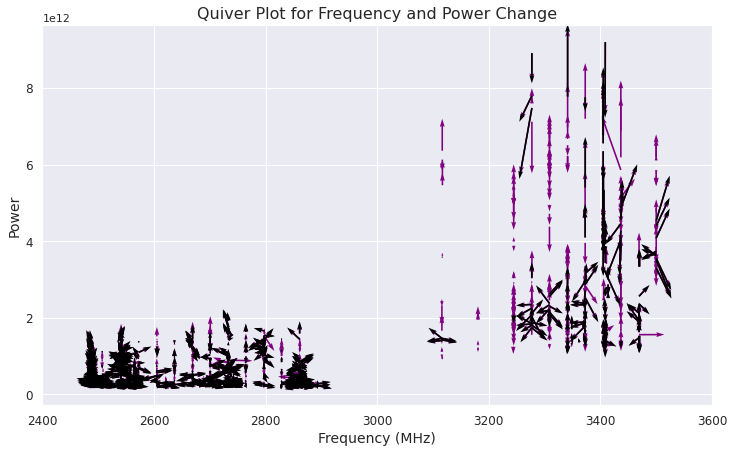

In [137]:
# Creating arrow
x_pos = nonzero_drift_rates['Frequency 1']
y_pos = nonzero_drift_rates['Power 1']
x_direct = nonzero_drift_rates['Frequency Difference']/1e6 #Divide by 10^6 to get the units from Hz to MHz
y_direct = np.array(nonzero_drift_rates['Power 1']-nonzero_drift_rates['Power 2'])/1e13 
#Divide by 10^13 to show the same units on the y-axis

# Creating arrow
x_position = drift_rate_kurtosis['Frequency 1']
y_position = drift_rate_kurtosis['Power 1']
x_direction = drift_rate_kurtosis['Frequency Difference']/1e6 #Divide by 10^6 to get the units from Hz to MHz
y_direction = np.array(drift_rate_kurtosis['Power 1']-drift_rate_kurtosis['Power 2'])/1e13 
#Divide by 10^13 to show the same units on the y-axis

# Creating plot
fig, ax = plt.subplots(figsize = (12, 7))

ax.quiver(x_position, y_position, x_direction, y_direction, color = 'purple')
ax.quiver(x_pos, y_pos, x_direct, y_direct, color = 'black')

ax.set_title('Quiver Plot for Frequency and Power Change', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Frequency (MHz)', fontsize = 14)
plt.ylabel('Power', fontsize = 14)
plt.xlim(2400, 3600)

# Show plot
plt.show()